In [2]:

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [07:05<00:00, 122MB/s] 
100% 28.6G/28.6G [07:05<00:00, 72.1MB/s]


In [3]:
!unzip -q airbus-ship-detection -d airbus-ship-detection

In [4]:
import numpy as np
import pandas as pd 
import os
from skimage.io import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.models import Model
from keras.layers import Input, Concatenate
from keras.layers import  UpSampling2D, Conv2D, MaxPooling2D
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import tensorflow as tf


TRAIN_V2='airbus-ship-detection/train_v2/'
SEGMENTATION ='airbus-ship-detection/train_ship_segmentations_v2.csv'

In [5]:
def dice_coeff(target, pred):
  smooth = 1.0
  intersection = K.sum(target * pred, axis=[1,2,3])
  union = K.sum(target, axis=[1,2,3]) + K.sum(pred, axis=[1,2,3])
  return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)


def loss(target, pred):
  bce = binary_crossentropy(target, pred)
  dice_loss = 1-dice_coeff(target, pred)
  return bce-tf.math.log(1-dice_loss)


def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decode a run-length encoded mask and return it as a numpy array.

    Args:
        mask_rle (str): Run-length encoded mask in the format (start length).
        shape (tuple): Desired shape (height, width) of the returned array.

    Returns:
        numpy.ndarray: Decoded mask where 1 represents the mask and 0 represents the background.

    """
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    mask_rle = mask_rle.split()
    mask_starts = [int(mask_rle[i]) - 1 for i in range(0, len(mask_rle), 2)]
    mask_lengths = [int(mask_rle[i + 1]) for i in range(0, len(mask_rle), 2)]
    for start, length in zip(mask_starts, mask_lengths):
        mask[start : start + length] = 1

    mask = mask.reshape(shape).T
    return mask

In [6]:
def show_example_data(ImageId, train_csv):
    """"
    Display an example of an image and its corresponding masks.
    """
    img = imread(os.path.join(TRAIN_V2, ImageId))
    img_masks = train_csv.loc[train_csv['ImageId'] == ImageId, 'EncodedPixels'].tolist()
    all_masks = np.zeros((768, 768))
    all_masks = np.bitwise_or.reduce([rle_decode(mask) for mask in img_masks], axis=0)

    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    for ax in axarr:
        ax.axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks)
    axarr[2].imshow(img)
    axarr[2].imshow(all_masks, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

In [7]:
def balance_data(train_csv, drop_no_ship_fraction = 0.8):
    """
    Balance the training data by removing images without ships and sampling a fraction of the remaining data.

    Args:
        train_csv (DataFrame): DataFrame containing the training data.
        drop_no_ship_fraction (float): Fraction of images without ships to drop. Default is 0.8.

    Returns:
        DataFrame: Balanced training data DataFrame, containing a subset of images with ships.

    """
    # Delete images without ships
    bal_train_csv=train_csv.set_index('ImageId').drop(
        train_csv.loc[
            train_csv.isna().any(axis=1),
            'ImageId'
        ]).reset_index()

    #Fraction of images
    bal_train_csv=bal_train_csv.sample( frac = drop_no_ship_fraction , random_state=1)
    
    return bal_train_csv

In [8]:
def masks_as_image(in_mask_list):
    """
    Take the individual ship masks and create a single mask array for all ships
    """
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return np.expand_dims(all_masks, -1)


In [9]:

def keras_generator(gen_df, batch_size=8):
    """
   Generate batches of RGB images and corresponding masks from the input DataFrame.
   
   Args:
       gen_df (DataFrame): DataFrame containing image and mask information.
       batch_size (int): Number of samples per batch. Default is BATCH_SIZE.
       
   Yields:
       tuple: A tuple containing the batch of RGB images and corresponding masks.
              The RGB images are normalized to the range [0, 1], and masks are not normalized.
   """
    IMG_SCALING = (3, 3)
    all_batches = list(gen_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(TRAIN_V2, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb.append(c_img)
            out_mask.append(c_mask)
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0).astype(float)                
                out_rgb, out_mask=[], []


In [10]:

def augment_images(images):
    """
    Generate augmented images and masks using image data augmentation.

    Args:
        images (iterable): Iterable containing pairs of original images and masks.

    Yields:
        tuple: A tuple containing the augmented images and masks.

    """
    # Define the augmentation settings
    aug_args = dict(
        rotation_range=45,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.01,
        zoom_range=[0.9, 1.25],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        brightness_range = [0.5, 1.5]
    )
    
    # Create an image data generator for augmentation
    image_datagen = ImageDataGenerator(**aug_args)
    
    # Create a mask data generator for augmentation
    aug_args_mask=aug_args.copy()
    del aug_args_mask['brightness_range']
    mask_datagen= ImageDataGenerator(**aug_args_mask)
        
    # Generate augmented images and masks
    for image, mask  in images:
        augmented_images = image_datagen.flow(255*image,  batch_size = image.shape[0], shuffle=True)
        augmented_masks = mask_datagen.flow(mask , batch_size = image.shape[0], shuffle=True)

        yield next(augmented_images)/255.0, next(augmented_masks)

In [13]:
class UNet(Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.build_model()
        
    def build_model(self):
        """
        Build the U-Net model architecture.
        """
        img = Input((256, 256, 3))

        c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(img)
        c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
        p1 = MaxPooling2D((2, 2))(c1)
        
        c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
        c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
        p2 = MaxPooling2D((2, 2))(c2)
        
        c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
        c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
        p3 = MaxPooling2D((2, 2))(c3)
        
        c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
        c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
        p4 = MaxPooling2D(pool_size=(2, 2))(c4)
        
        c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
        c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
        
        u6 = UpSampling2D((2, 2))(c5)
        u6 = Concatenate()([u6, c4])
        c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
        c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
        
        u7 = UpSampling2D((2, 2))(c6)
        u7 = Concatenate()([u7, c3])
        c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
        c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
        
        u8 = UpSampling2D((2, 2))(c7)
        u8 = Concatenate()([u8, c2])
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    
        u9 = UpSampling2D((2, 2)) (c8)
        u9 = Concatenate()([u9, c1])
        c9 = Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
        c9 = Conv2D(8, (3, 3), activation='relu', padding='same')(c9)

        o = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c9)

        self.unet_model = Model(inputs=[img], outputs=[o])
        self.unet_model.summary()
        
        
    def compile_model(self):
        """
        Compile the U-Net model.
        """                   
        #self.adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        self.adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)           
        self.unet_model.compile(optimizer='adam', loss=loss, metrics=[ 'binary_accuracy'])


    def fit_model(self, train_csv, valid_csv, epochs):
        """
        Fit the U-Net model to the training data.
        """
        self.batch_size = 12
        self.steps_per_epoch=50
        self.validation_steps=50
        self.history = self.unet_model.fit(augment_images(keras_generator(train_csv,self.batch_size)),
                                           steps_per_epoch=self.steps_per_epoch,
                                           epochs=epochs,
                                           validation_data=keras_generator(valid_csv),
                                           validation_steps=self.validation_steps)

       
    def evaluate_model(self):
        """
        Evaluate and plot the training and validation results.
        """  
        fig = plt.figure()
        pyplot.plot(self.history.history['loss'], label='train')
        pyplot.plot(self.history.history['val_loss'], label='test')
        pyplot.title('loss')
        pyplot.ylabel('loss')
        pyplot.xlabel('epoch')
        pyplot.legend()
        pyplot.show()
        
        fig = plt.figure()
        pyplot.plot(self.history.history['binary_accuracy'], label='train')
        pyplot.plot(self.history.history['val_binary_accuracy'], label='test')
        pyplot.title('binary_accuracy')
        pyplot.ylabel('binary_accuracy')
        pyplot.xlabel('epoch')
        pyplot.legend()
        pyplot.show()


    def save_model(self):
        # Save the model
        self.unet_model.save('unet_model.h5')

Len train_v2: 192556
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


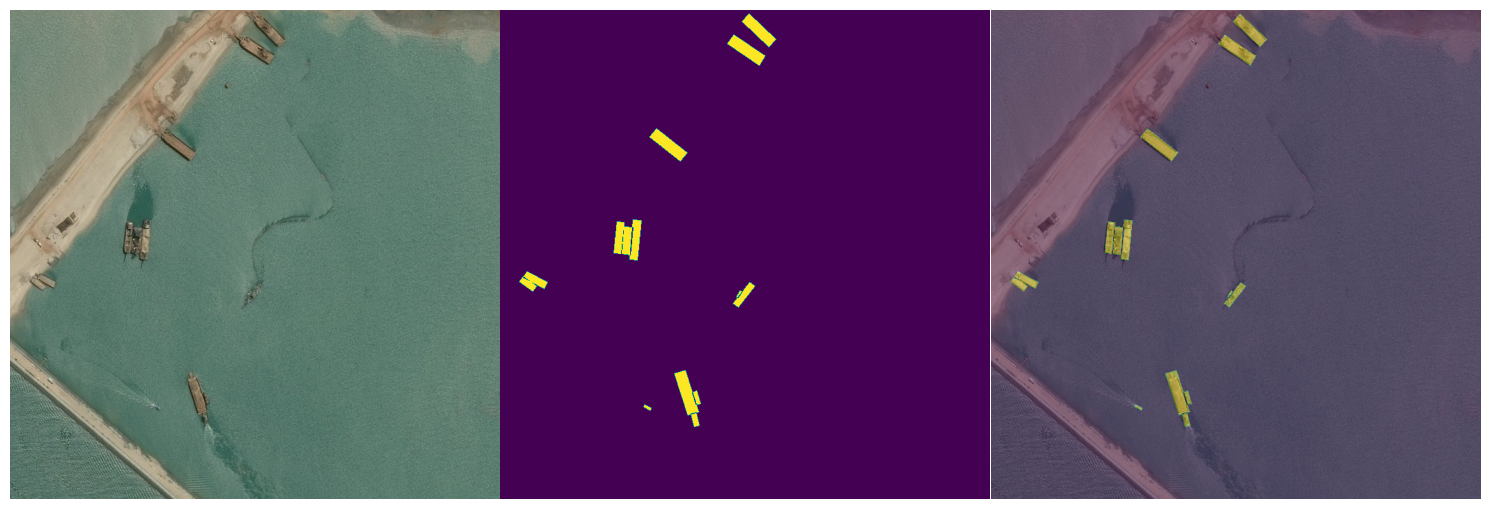

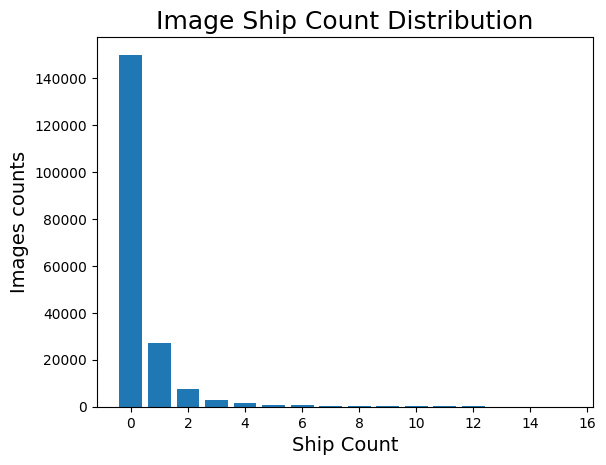

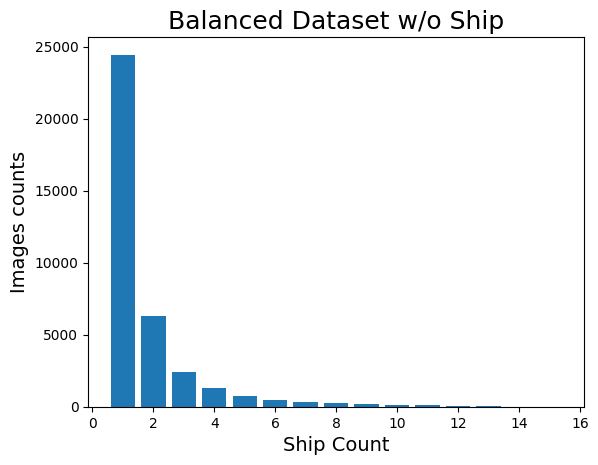

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 8)  224         ['input_2[0][0]']                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 8)  584         ['conv2d_19[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 8)  0          ['conv2d_20[0][0]']        

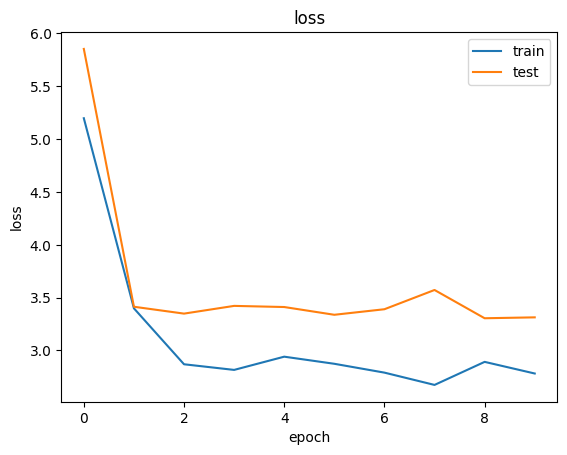

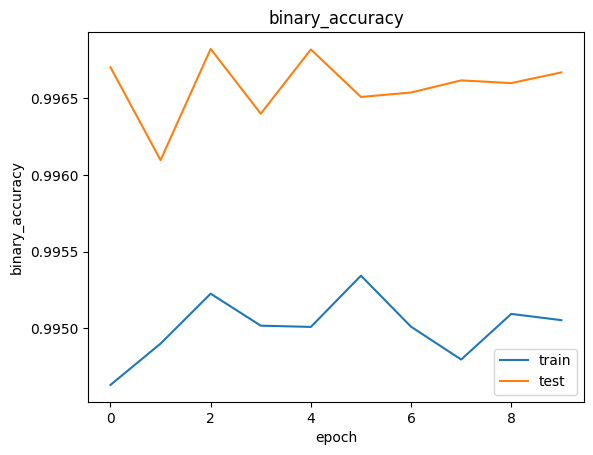

In [14]:
            
def main():
    # Load and inspect the data           
    train_v2 = os.listdir(TRAIN_V2)
    print("Len train_v2:",len(train_v2))
    train_csv = pd.read_csv(SEGMENTATION)
    print(train_csv.head())

    # Example data
    ImageId='0a1a7f395.jpg'
    show_example_data(ImageId,train_csv)    
    
    # Image Ship Count Distribution
    ship_count  = train_csv['EncodedPixels'].notnull().astype(int).groupby(train_csv['ImageId']).sum().value_counts()
    plt.bar(ship_count .index, ship_count .values)
    plt.xlabel('Ship Count', fontsize=14)
    plt.ylabel('Images counts', fontsize=14)
    plt.title('Image Ship Count Distribution', fontsize=18)
    plt.show()
       
    # Balance the data
    train_csv=balance_data(train_csv)
        
    # Balanced Dataset w/o Ship
    ship_count  = train_csv['EncodedPixels'].notnull().astype(int).groupby(train_csv['ImageId']).sum().value_counts()
    plt.bar(ship_count .index, ship_count .values)
    plt.xlabel('Ship Count', fontsize=14)
    plt.ylabel('Images counts', fontsize=14)
    plt.title('Balanced Dataset w/o Ship', fontsize=18)
    plt.show()
           
    # Split train and validate data
    train_csv, valid_csv = train_test_split(train_csv, test_size = 0.3)
    
    # Set epochs
    epochs = 10
    
    # Create and train the UNet model
    unet_model = UNet()
    unet_model.compile_model()
    unet_model.fit_model(train_csv, valid_csv, epochs)
    unet_model.evaluate_model()
    unet_model.save_model()

              
if __name__ == '__main__':
    main()            
            
            